In [1]:
import pathlib
import math
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_selection import f_classif, mutual_info_classif, r_regression, RFE, chi2
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_70371/3187784765.py:12: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [2]:
region_groups = {}
region_groups['overall'] = ['Abnormal facial shape',
                            'Long face',
                            'Microcephaly', 
                            'Hypopigmentation of the skin', 
                            'Elfin facies',
                            'Narrow face',
                            'Coarse facial features',
                            'Triangular face',
                            'Midface retrusion',
                            'Webbed neck']
region_groups['hair'] = ['Fair hair']
region_groups['eye'] = ['Epicanthus',
                        'Upslanted palpebral fissure',
                        'Abnormal eyelid morphology',
                        'Ptosis',
                        'Telecanthus',
                        'Strabismus',
                        'Iris hypopigmentation',
                        'Blepharophimosis',
                        'Downslanted palpebral fissures',
                        'Hypertelorism',
                        'Proptosis',
                        'Highly arched eyebrow',
                        'Sparse lateral eyebrow',
                        'Long eyelashes',
                        'Eversion of lateral third of lower eyelids']
region_groups['nose'] = ['Prominent nasal bridge',
                         'Wide nasal bridge',
                         'Bulbous nose',
                         'Short nose',
                         'Short columella']
region_groups['ears'] = ['Low-set ears',
                         'Overfolded helix',
                         'Small earlobe',
                         'Low-set posteriorly rotated ears',
                         'Protruding ear',
                         'Thickened helices',
                         'Macrotia']
region_groups['mouth'] = ['Long philtrum',
                          'Wide mouth',
                          'Protruding tongue',
                          'Thick lower lip vermilion',
                          'Everted lower lip vermilion',
                          'Open bite',
                          'Widely spaced teeth',
                          'Microdontia',
                          'Abnormality of the dentition']
region_groups['chin'] = ['Pointed chin']
region_groups['forehead'] = ['High forehead',
                             'Broad forehead']
hpo_terms = []
for group in region_groups:
    hpo_terms += region_groups[group]
hpo_terms = list(set(hpo_terms))

dataset_folder = '/media/omersumer/DATA/databases/NIH-Faces'
hpo_terms_from_csv_files = []
image_names = []
for syndrome in ['22q11DS', 'Angelman', 'KS', 'NS', 'WS']:
    df = pd.read_csv(pathlib.Path(dataset_folder, 'metadata', 'hpo-annotations', '%s.csv'%syndrome))
    hpo_terms_from_csv_files += df.keys()[2:-1].to_list()
    image_names += df['image_name'].to_list()
assert(len([i for i in set(hpo_terms_from_csv_files) if i not in hpo_terms])==0)

df = pd.read_csv(pathlib.Path(dataset_folder, 'metadata', 'partitions.csv'))

print('I do not have these images in the database:')
print([i for i in image_names if i not in df['image_name'].to_list()])

I do not have these images in the database:
['22q11DSSlide150.png', 'KSSlide133.png', 'NSSlide6.png', 'WSSlide316.png']


In [3]:
hpo_occurrence = np.zeros(shape=(len(image_names), len(hpo_terms)), dtype=np.uint8)

for i in range(0, len(image_names)):
    syndrome = image_names[i].split('Slide')[0]
    df = pd.read_csv(pathlib.Path(dataset_folder, 'metadata', 'hpo-annotations', '%s.csv'%syndrome))
    index = np.argwhere(df['image_name'].to_numpy()==image_names[i]).squeeze()
    #print(image_names[i], syndrome, index)
    
    for key in list(df.iloc[index][2:-1].keys()):
        #print(key)
        j = np.argwhere(np.array(hpo_terms) == key).squeeze()
        assert(j.size==1)

        # Annotations: 0, X, 2X, 3X
        if df.iloc[index][key] is np.nan:
            val = 0 
        elif df.iloc[index][key]=='1X':
            val = 1
        elif df.iloc[index][key]=='2X':
            val = 2
        elif df.iloc[index][key]=='3X':
            val = 3
        else:
            raise Exception('Check values: %s, %s, %s'%(syndrome, image_names[i], key))

        hpo_occurrence[i, j] = val
        
df = pd.DataFrame({'image_name':image_names, 'category':[i.split('Slide')[0]  for i in image_names]})
df = pd.concat([df, pd.DataFrame(hpo_occurrence)], axis=1)
#df = df.set_index('image_name') 

In [4]:
df

,image_name,category,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,22q11DSSlide51.png,22q11DS,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,22q11DSSlide52.png,22q11DS,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22q11DSSlide105.png,22q11DS,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22q11DSSlide150.png,22q11DS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,3,0,0,0
4,22q11DSSlide153.png,22q11DS,2,0,0,0,0,0,0,0,...,0,0,1,0,0,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,WSSlide409.png,WS,0,3,2,1,0,0,0,0,...,0,0,0,2,0,0,0,0,3,0
171,WSSlide456.png,WS,0,1,0,1,1,0,0,0,...,0,0,0,2,0,0,0,0,3,1
172,WSSlide487.png,WS,0,1,1,0,0,0,0,0,...,0,0,0,2,0,0,0,0,3,3
173,WSSlide533.png,WS,0,2,1,0,2,0,0,0,...,0,0,0,1,0,0,0,0,3,0


In [5]:
features = df.loc[:,0:].to_numpy()
labels = np.array([np.argwhere(df.iloc[i]['category']==np.array(sorted(set(df['category'].to_list())))).squeeze() for i in range(0, df.shape[0])])
print(sorted(set(df['category'].to_list())))

['22q11DS', 'Angelman', 'KS', 'NS', 'WS']


X_embedded.shape= (175, 2)


/tmp/ipykernel_70371/3852240997.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(hpo_terms, rotation=270)


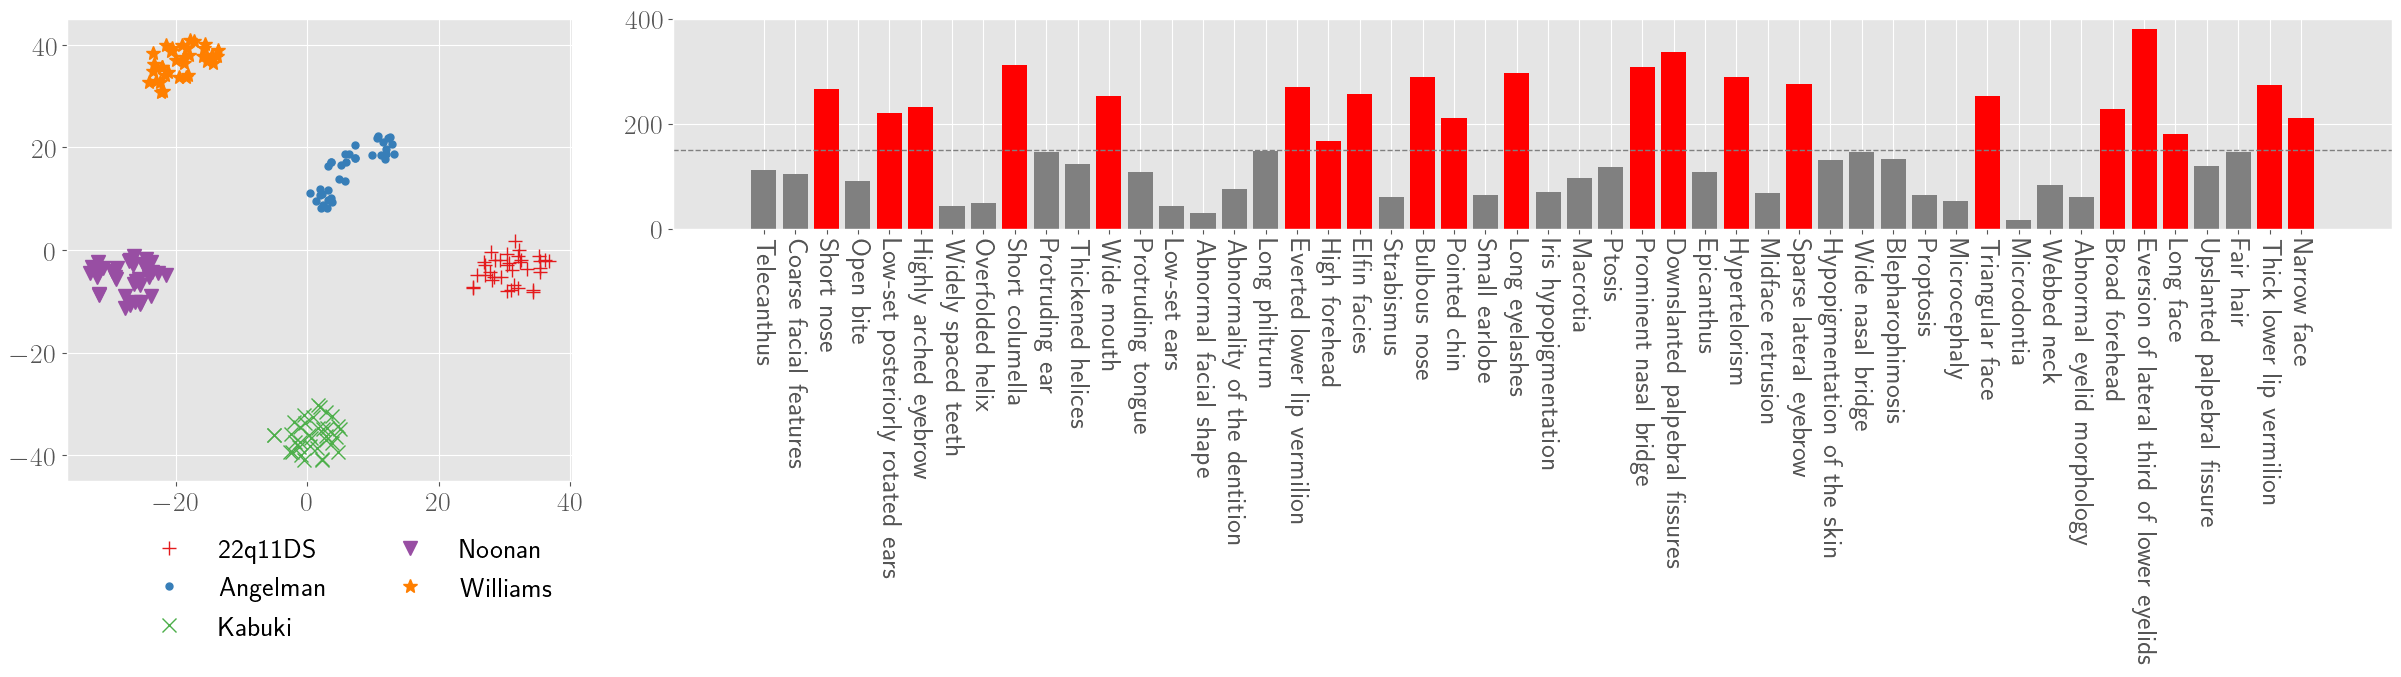

In [6]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10).fit_transform(df.loc[:,2:].to_numpy())
print('X_embedded.shape=', X_embedded.shape)


#fig, axes = plt.subplots(1, 2, figsize=(30, 6), gridspec_kw={'width_ratios': [1, 3]})
fig = plt.figure(figsize=(30, 6)) # constrained_layout=True, 
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[:, 0])
#ax1.set_title('t-SNE embeddings using labeled HPO terms', fontsize=14)
categories = ['22q11DS', 'Angelman', 'Kabuki', 'Noonan', 'Williams']
cmap = matplotlib.cm.get_cmap("Set1")
symbols = ['+', '.', 'x','v','*']
for i in range(0, 5):
    ax1.plot(X_embedded[labels==i,0], X_embedded[labels==i,1], symbols[i], c=cmap(i), label=categories[i], markersize=10)
ax1.legend(bbox_to_anchor=(1.01, -0.07), ncol=2, fontsize=20, facecolor='white',edgecolor='white')
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2 = fig.add_subplot(gs[0, 1:])
#ax2.set_title('Chi2 statistics for importance of each annotated HPO term.', fontsize=14)
chi2_values = chi2(features, labels)[0]
for i in range(0, len(hpo_terms)):
    if chi2_values[i]<150:
        ax2.bar(hpo_terms[i], chi2_values[i], color='gray') # r'\textbf{%s}'%
    else:
        ax2.bar(hpo_terms[i], chi2_values[i], color='red')
    

ax2.axhline(y=150, linewidth=1, color='gray',linestyle='--')
ax2.set_xticklabels(hpo_terms, rotation=270)
ax2.set_ylim(0, 400)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('fig-syndrome-distrobution-hist.svg', bbox_inches="tight", pad_inches=0.2)
plt.show()